In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
from astropy import constants as const
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
import math
import time

from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN

import scipy
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.stats import multivariate_normal
from scipy.stats import bootstrap
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler


colors = ['red', 'yellow', 'blue']
custom_cmap = ListedColormap(colors)

In [2]:
dataLI = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\STPM_improv+ed_210721.csv",delimiter=",")
dataEA = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\2024sample_composite.csv",delimiter=",")

dataLInew = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\stpm_230202.csv",delimiter=",")
planet_name_LI        = list(dataLI["Star"]+" "+dataLI["Planet"])
dataLI["planet_name"] = planet_name_LI
planet_LI_NEW         = list(dataLInew["Star"]+" "+dataLInew["Planet"])
dataLInew["planet_name"] = planet_LI_NEW
earth_like_rocky  = pd.read_csv(r"C:\Users\silke\Desktop\Thesis\Mass_Radius_Curves\Earth-like Rocky (32.5% Fe+67.5% MgSiO3).txt",delimiter = "\t")

earth_Mass = const.M_earth.value*1000 #g
earth_Radius = const.R_earth.value*100
earth_Volume = 4/3 * math.pi * earth_Radius**3
earth_density = earth_Mass / earth_Volume

In [3]:
# Luque Impoved
planet_id_LI         = dataLI.ID
star_name_LI         = dataLI.Star
planet_letter_LI     = dataLI.Planet

radius_LI            = dataLI.R_Rterra            # [Earth Radius]
radius_unc_up_LI     = dataLI.euR_Rterra          # [Earth Radius] Upper Unc.
radius_unc_low_LI    = dataLI.edR_Rterra          # [Earth Radius] Lower Unc.

mass_LI              = dataLI.M_Mterra            # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]
mass_unc_up_LI       = dataLI.euM_Mterra          # [Earth Mass] Upper Unc.
mass_unc_low_LI      = dataLI.edM_Mterra          # [Earth Mass] Lower Unc.

density_LI           = dataLI[dataLI.columns[32]]  # [g/cm**3]
density_unc_up_LI    = dataLI[dataLI.columns[33]]  # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_LI   = dataLI[dataLI.columns[34]]  # [g/cm**3] Planet Density Lower Unc
star_eff_LI          = dataLI.Teff_K
pl_eq_LI             = dataLI.Teq_K                # [K] Equilibrium Temperature

# Luque Impoved New
planet3 = planet_LI_NEW 
# Exoplanet Archive
planet_name_EA       = dataEA.pl_name
planet_id_EA         = list(range(0,len(planet_name_EA)))

radius_EA            = dataEA.pl_rade            # [Earth Radius]
period_EA            = dataEA.pl_orbper          # [days]
radius_unc_up_EA     = dataEA.pl_radeerr1        # [Earth Radius] Upper Unc.
radius_unc_low_EA    = dataEA.pl_radeerr2        # [Earth Radius] Lower Unc.
mass_EA              = dataEA.pl_bmasse          # [Earth Mass] - Planet Mass or Mass*sin(i) [Earth Mass]

mass_unc_up_EA       = dataEA.pl_bmasseerr1      # [Earth Mass] Upper Unc.
mass_unc_low_EA      = dataEA.pl_bmasseerr2      # [Earth Mass] Lower Unc.

density_EA           = dataEA.pl_dens            # [g/cm**3]
density_unc_up_EA    = dataEA.pl_denserr1        # [g/cm**3] Planet Density Upper Unc. 
density_unc_low_EA   = dataEA.pl_denserr2        # [g/cm**3] Planet Density Lower Unc. 
st_spectype_EA       = dataEA.st_spectype        # Spectral type of star
pl_eq_EA             = dataEA.pl_eqt             # [K] Equilibrium Temperature
st_eff_EA            = dataEA.st_teff            # Star effective temprature
st_eff_up_EA         = dataEA.st_tefferr1        # Star upper err effective temprature
st_eff_low_EA        = dataEA.st_tefferr2        # Star lower err effective temprature
disc_year_EA         = dataEA.disc_year


In [4]:
planets = ["K2-146 b",'TRAPPIST-1 h', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 c', 'TRAPPIST-1 b', 'GJ 1132 b', 'TOI-270 b', 'GJ 3053 c', 'GJ 1252 b', 'GJ 357 b', 'LTT 3780 b', 'LHS 1478 b', 'GJ 486 b', 'GJ 3473 b', 'CD-60 8051 b', 'L 98-59 c', 'L 98-59 d', 'GJ 3053 b', 'TOI-270 d', 'TOI-776 b', 'TOI-1634 b', 'TOI-1685 b', 'TOI-1235 b', 'K2-146 c', 'LTT 3780 c', 'TOI-270 c', 'K2-18 b', 'TOI-269 b', 'GJ 1214 b', 'K2-25 b', 'TOI-1231 b']
planet1      = []; planet_i1       = []; planet_eq1   = []
disc_year1   = []; st_eff1         = []; st_type1     = []
radius1      = []; radius_up1      = []; radius_low1  = []
mass1        = []; mass_up1        = []; mass_low1    = []
density1     = []; density_up1     = []; density_low1 = []

for i in range(0,len(planet_name_LI)):
    if planet_name_LI[i] in planets:
        planet1.append(planet_name_LI[i]); planet_eq1.append(pl_eq_LI[i]);          st_eff1.append(star_eff_LI[i]);
        radius1.append(radius_LI[i]);      radius_up1.append(radius_unc_up_LI[i]);  radius_low1.append(radius_unc_low_LI[i]);
        mass1.append(mass_LI[i]);          mass_up1.append(mass_unc_up_LI[i]);      mass_low1.append(mass_unc_low_LI[i]);
        density1.append(density_LI[i]);    density_up1.append(density_unc_up_LI[i]); density_low1.append(density_unc_low_LI[i]);

In [5]:
planet_EA_unique = list(set(planet_name_EA))
other_names = ["LHS 1140 b",'LHS 1140 c' ,'L 168-9 b', 'L 168-9 c', "GJ 3053 b","GJ 3053 c"]

radius_4_crit     = []
mass_err_crit     = []
radius_err_crit   = []
stellar_type_crit = []
st_eff_crit       = []
density_crit      = []
for i in range(0,len(planet_name_EA)):
    if planet_name_EA[i] not in planet_name_LI and planet_name_EA[i] not in other_names and planet_name_EA[i]:
        if planet_name_EA[i] not in radius_4_crit and radius_EA[i]<4:
            radius_4_crit.append(planet_name_EA[i])
        if planet_name_EA[i] not in mass_err_crit and ((mass_unc_up_EA[i] + mass_unc_up_EA[i])*0.5) / mass_EA[i] < 0.50:
            mass_err_crit.append(planet_name_EA[i])    
        if planet_name_EA[i] not in radius_err_crit and ((radius_unc_up_EA[i] + radius_unc_up_EA[i])*0.5) / radius_EA[i] < 0.50:
            radius_err_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in stellar_type_crit and "M" in str(st_spectype_EA[i]):
            stellar_type_crit.append(planet_name_EA[i])   
        if planet_name_EA[i] not in density_crit and True != math.isnan(density_unc_up_EA[i]):
            density_crit.append(planet_name_EA[i])   

list1 = radius_4_crit;   list2 = mass_err_crit; 
list3 = radius_err_crit; list4 = stellar_type_crit; 
list5 = density_crit

common_elements = np.sort(list(set(list1) & set(list2) & set(list3) & set(list4) & set(list5)))

planet2      = []; planet_i2       = []; planet_eq2   = []
disc_year2   = []; st_eff2         = []
radius2      = []; radius_up2      = []; radius_low2  = []
mass2        = []; mass_up2        = []; mass_low2    = []
density2     = []; density_up2     = []; density_low2 = []

for j in range(0,len(common_elements)):
    target_string = str(common_elements[j])
    indexs = [index for index, value in enumerate(planet_name_EA) if value == target_string]
    i = indexs[0]
    if st_eff_EA[i] < 4000:
        st_eff2.append(st_eff_EA[i])
        planet_eq2.append(pl_eq_EA[i]); planet2.append(planet_name_EA[i]); disc_year2.append(disc_year_EA[i])
        radius2.append(dataEA.pl_rade[i]); radius_up2.append(dataEA.pl_radeerr1[i]); radius_low2.append(dataEA.pl_radeerr2[i])
        density2.append(dataEA.pl_dens[i]); density_up2.append(dataEA.pl_denserr1[i]); density_low2.append(dataEA.pl_denserr2[i])
        mass2.append(dataEA.pl_bmasse[i]); mass_up2.append(dataEA.pl_bmasseerr1[i]);  mass_low2.append(dataEA.pl_bmasseerr2[i])


In [7]:
len(st_eff2)

21

In [7]:
earth_like_rocky_mass_g        = earth_Mass*np.array(earth_like_rocky["Mass"])
earth_like_rocky_radius_cm     = earth_Radius*np.array(earth_like_rocky["Radius"])
earth_like_rocky_density_g_cm3 = (earth_like_rocky_mass_g) / ((4/3)*(np.pi)*(np.power(earth_like_rocky_radius_cm,3))   ) 

def rocky_density(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def rocky_density2(mass):
    x_points  = earth_like_rocky["Mass"]
    y_points  = earth_like_rocky_density_g_cm3/earth_like_rocky_density_g_cm3
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

def h20model_density(mass):
    x_points  = H20_50_500K["Mass"]
    y_points  = H20_50_500K_density_g_cm3/rocky_density(H20_50_500K["Mass"])
    tck       = interpolate.splrep(x_points, y_points)
    return interpolate.splev(mass, tck).tolist()

mass    = np.concatenate((mass1, mass2));       mass_up     = np.concatenate((mass_up1, mass_up2));       mass_low     = np.concatenate((mass_low1, mass_low2));
radius  = np.concatenate((radius1, radius2));   radius_up   = np.concatenate((radius_up1, radius_up2));   radius_low   = np.concatenate((radius_low1, radius_low2));
density = np.concatenate((np.array(density1) / rocky_density(mass1), np.array(density2)/ rocky_density(mass2))); density_up  = np.concatenate((np.array(density_up1)/ rocky_density(mass1), np.array(density_up2)/ rocky_density(mass2))); density_low  = np.concatenate((np.array(density_low1)/ rocky_density(mass1),np.array(density_low2)/ rocky_density(mass2)));

planet_temp = np.concatenate((planet_eq1, planet_eq2));
planet_name = np.concatenate((planet1,    planet2));
star_eff    = np.concatenate((st_eff1,    st_eff2));
disc_year   = np.concatenate((disc_year1,    disc_year2));

mass_err    = [np.abs(mass_low),mass_up]
radius_err  = [np.abs(radius_low),radius_up]
density_err = [np.abs(density_low),density_up]

mass10      = np.log10(mass)
mass10_up   = np.log10(mass + mass_up) - np.log10(mass)
mass10_low  = np.log10(mass + np.abs(mass_low)) - np.log10(mass)
mass10_err  = [mass10_low,mass10_up]

model_rocky_density = np.array(rocky_density(np.array(earth_like_rocky["Mass"])))
model_rocky_mass    = np.array(earth_like_rocky["Mass"])
model_rocky10_mass  = np.array(np.log10(np.array(earth_like_rocky["Mass"])))
model_rocky_radius  = np.array(earth_like_rocky["Radius"])

In [9]:
list1 = mass_up
list2 = np.abs(mass_low)
mass_err = [max(val1, val2) for val1, val2 in zip(list1, list2)]
list1 = radius_up
list2 = np.abs(radius_low)
radius_err = [max(val1, val2) for val1, val2 in zip(list1, list2)]

In [8]:
pl_df = pd.DataFrame()
pl_df["Name"]       = planet_name
pl_df["Mass"]       = mass
pl_df["Mass10"]     = mass10
pl_df["Mass_err"]   = mass_err
pl_df["Radius"]     = radius
pl_df["Radius_err"] = radius_err
pl_df["Density"]    = density
pl_df["Temp"]       = planet_temp
pl_df["Temp_err"]   = 0.02*planet_temp

# Display the DataFrame

#output_file_path = 'Planet_parameters'
#pl_df.to_csv(output_file_path, sep='\t', index=False)
#print(f'All lines of the DataFrame have been written to {output_file_path}.')

ValueError: Length of values (2) does not match length of index (55)

In [10]:
planet_name

array(['GJ 3053 b', 'GJ 3053 c', 'LHS 1478 b', 'TOI-1634 b', 'TOI-1685 b',
       'GJ 3473 b', 'L 98-59 c', 'L 98-59 d', 'K2-146 b', 'K2-146 c',
       'GJ 357 b', 'TOI-1235 b', 'GJ 1132 b', 'LTT 3780 b', 'LTT 3780 c',
       'K2-18 b', 'TOI-776 b', 'GJ 486 b', 'GJ 1214 b', 'GJ 1252 b',
       'TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e',
       'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 h', 'CD-60 8051 b',
       'TOI-270 b', 'TOI-270 c', 'TOI-270 d', 'K2-25 b', 'TOI-269 b',
       'TOI-1231 b', 'AU Mic c', 'GJ 3090 b', 'GJ 367 b', 'GJ 3929 b',
       'GJ 806 b', 'HD 260655 b', 'HD 260655 c', 'Kepler-26 b',
       'Kepler-26 c', 'L 98-59 b', 'LTT 1445 A b', 'LTT 1445 A c',
       'TOI-1075 b', 'TOI-1201 b', 'TOI-1452 b', 'TOI-1470 b',
       'TOI-1470 c', 'TOI-1695 b', 'TOI-1801 b', 'TOI-2136 b',
       'TOI-244 b'], dtype='<U12')

In [11]:
density1_norm      = np.array(density1) / rocky_density(mass1)
density1_up_norm   = np.array(density_up1)/ rocky_density(mass1)
density1_low_norm  = np.array(density_low1)/ rocky_density(mass1)

mass10_1_norm      = np.log10(mass1)
mass10_1_up_norm   = np.log10(np.array(mass1) + np.array(mass_up1)) - np.log10(mass1)
mass10_1_low_norm  = np.log10(np.array(mass1) + np.array(np.abs(mass_low1))) - np.log10(mass1)


In [12]:
all_predictions = pd.read_csv(r"C:\Users\silke\Desktop\more_examples\All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Planet Name'])
all_predictions = all_predictions.drop('Planet Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

# 5000th row

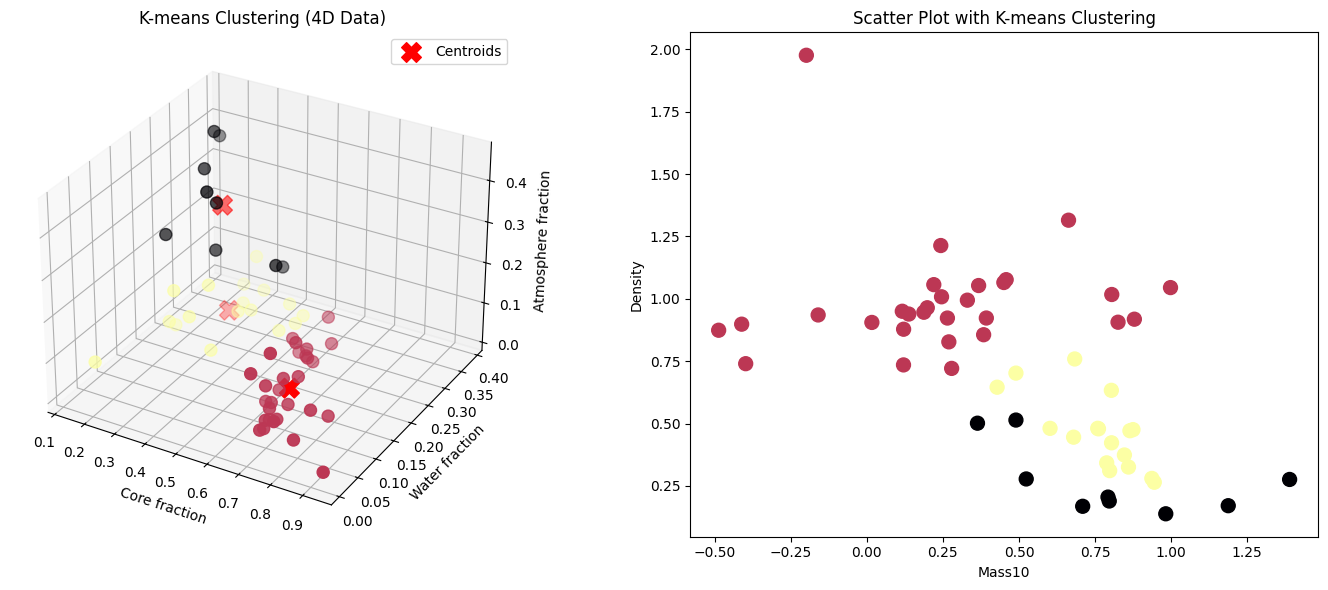

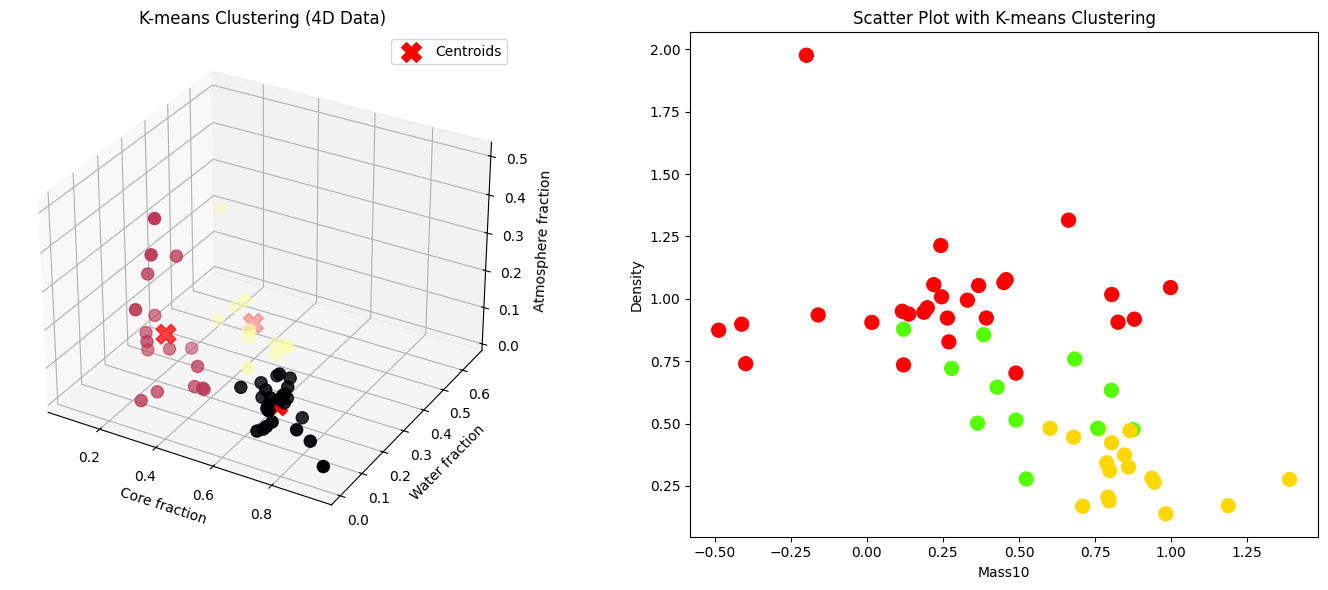

In [13]:
every_5000th_row = all_predictions.iloc[0::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

# Combine the lists to create the 4D dataset
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)

# Visualize the clusters in a 3D plot
fig = plt.figure(figsize=(14, 6))

# Subplot for 3D plot
ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap='inferno', s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction'); ax1.set_ylabel('Water fraction'); ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

# Subplot for 2D scatter plot
ax2 = fig.add_subplot(122)
scatter_2d = ax2.scatter(mass10, density, c=labels, cmap='inferno',s = 100)
ax2.set_title('Scatter Plot with K-means Clustering'); ax2.set_xlabel('Mass10'); ax2.set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
plt.show()

every_5000th_row = all_predictions.iloc[1::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)

# Combine the lists to create the 4D dataset
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)

# Visualize the clusters in a 3D plot
fig = plt.figure(figsize=(14, 6))

# Subplot for 3D plot
ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap='inferno', s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction'); ax1.set_ylabel('Water fraction'); ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

# Subplot for 2D scatter plot
ax2 = fig.add_subplot(122)
scatter_2d = ax2.scatter(mass10, density, c=labels, cmap='prism',s = 100)
ax2.set_title('Scatter Plot with K-means Clustering'); ax2.set_xlabel('Mass10'); ax2.set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
plt.show()

NameError: name 'custom_cmap' is not defined

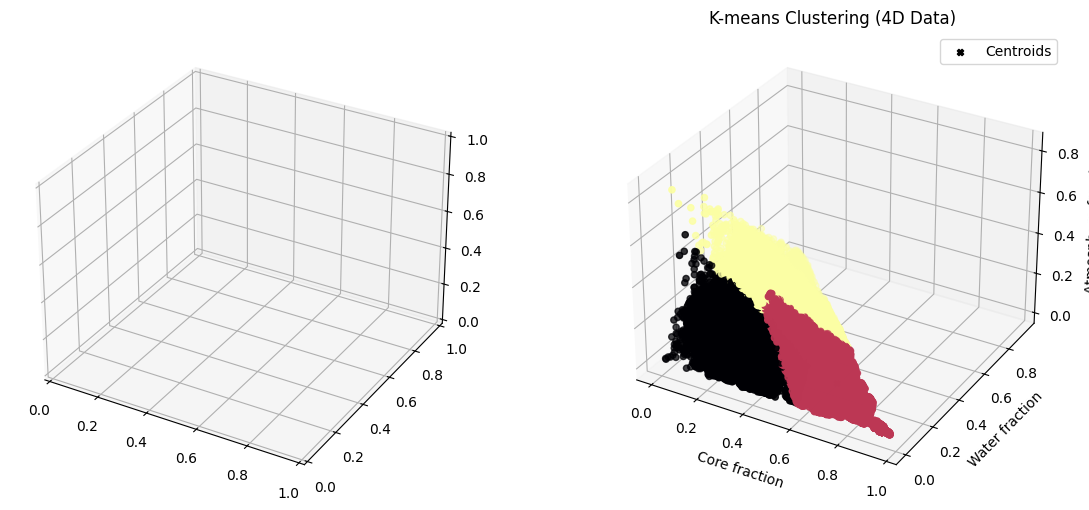

In [14]:
X = np.column_stack((all_predictions['Core'], all_predictions['Mantle'], all_predictions['Water'], all_predictions['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)

# Visualize the clusters in a 3D plot
fig = plt.figure(figsize=(14, 6))

# Subplot for 3D plot
ax1 = fig.add_subplot(122, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap='inferno')
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='black', marker='X', label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction'); ax1.set_ylabel('Water fraction'); ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)
# Subplot for 3D plot
ax2 = fig.add_subplot(121, projection='3d')
scatter_3d = ax2.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap=custom_cmap, s=75)
centroids = kmeans.cluster_centers_
ax2.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='black', marker='X', s=200, label='Centroids')
ax2.set_title('K-means Clustering (4D Data)')
ax2.set_xlabel('Core fraction')
ax2.set_ylabel('Water fraction')
ax2.set_zlabel('Atmosphere fraction')
ax2.legend()


plt.tight_layout(w_pad=5.0)
plt.show()

# KMeans label prediction
## 3 clusters

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

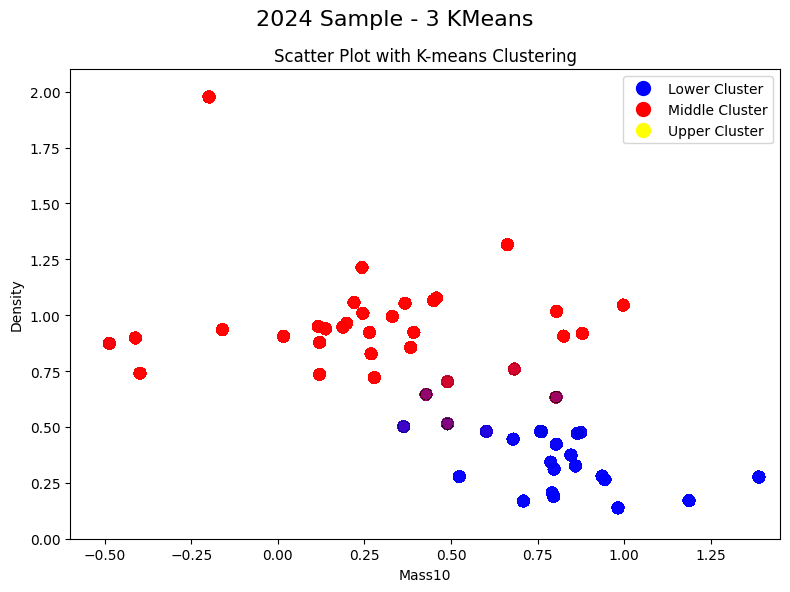

KeyError: "['KNN3: Middle Cluster'] not in index"

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('2024 Sample - 3 KMeans', fontsize=16)

all_predictions = pd.read_csv(r"C:\Users\silke\Desktop\more_examples\All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 250
np.random.seed(42)
colors = ['red', 'yellow', 'blue']
custom_cmap = ListedColormap(colors)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    #X = np.column_stack((np.log(every_5000th_row['Mantle']/every_5000th_row['Core']), np.log(every_5000th_row['Water']/every_5000th_row['Core']),np.log(every_5000th_row['Atmosphere']/every_5000th_row['Core'])))

    kmeans = KMeans(n_clusters=3,n_init = 10)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == mid_variable:
            new_labels[i] = 0
        if labels[i] == max_variable:
            new_labels[i] = 1
    plt.scatter(mass10, density, c=new_labels, s= 75, alpha = 0.002, cmap=custom_cmap,edgecolor=None)
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)
plt.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
plt.plot(3,3,"r.",label = "Middle Cluster",markersize=20)
plt.plot(3,3,".",color= "yellow",label = "Upper Cluster",markersize=20)

plt.title('Scatter Plot with K-means Clustering'); plt.xlabel('Mass10'); plt.ylabel('Density')
plt.xlim(-0.6,1.45); plt.ylim(0,2.1)

plt.legend()
plt.tight_layout(w_pad=5.0)
plt.show()

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KNN_labels3 = pd.DataFrame(counts_per_list).fillna(0).astype(int)

KNN_labels3['Name'] = planet_name
KNN_labels3 = KNN_labels3.rename(columns={2: 'KNN3: Lower Cluster'})
KNN_labels3 = KNN_labels3.rename(columns={0: 'KNN3: Middle Cluster'})
KNN_labels3 = KNN_labels3.rename(columns={1: 'KNN3: Upper Cluster'})

desired_order = ['Name', 'KNN3: Lower Cluster', "KNN3: Middle Cluster","KNN3: Upper Cluster"]
KNN_labels3 = KNN_labels3[desired_order]
#KNN_labels3
image_name = '3KMeans.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

## 2 Custers

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 

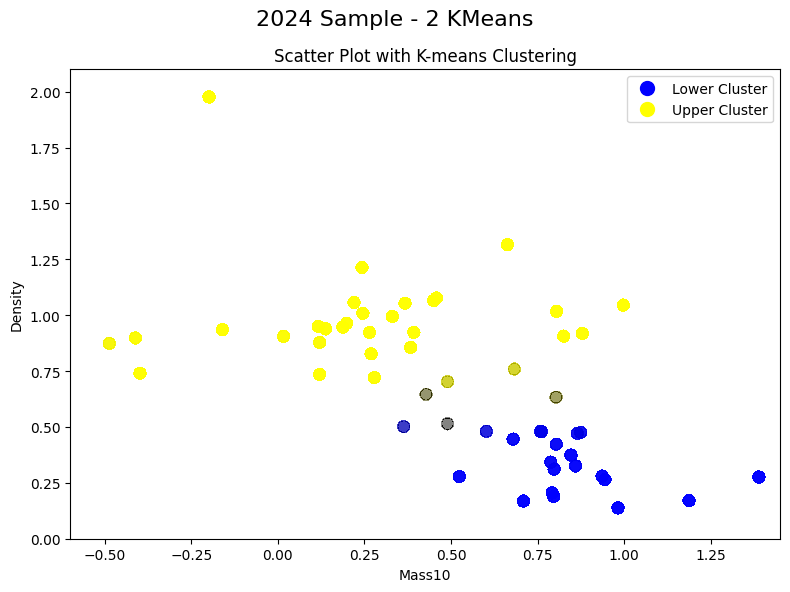

In [41]:
fig, ax = plt.subplots(figsize=(8,6))
fig.suptitle('2024 Sample - 2 KMeans', fontsize=16)

all_predictions = pd.read_csv(r"C:\Users\silke\Desktop\more_examples\All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))

number_of_runs = 250
np.random.seed(42)
colors = ['yellow', 'red', 'blue']
custom_cmap = ListedColormap(colors)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    kmeans = KMeans(n_clusters=2,n_init = 10)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == max_variable:
            new_labels[i] = 1
    plt.scatter(mass10, density, c=new_labels, s= 75, alpha = 0.002, cmap=custom_cmap,edgecolor=None)
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)
plt.plot(3,3,"b.",label = "Lower Cluster",markersize=20)
plt.plot(3,3,".",color = "yellow",label = "Upper Cluster",markersize=20)

plt.title('Scatter Plot with K-means Clustering'); plt.xlabel('Mass10'); plt.ylabel('Density')
plt.xlim(-0.6,1.45); plt.ylim(0,2.1)

plt.legend()
plt.tight_layout(w_pad=5.0)

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KNN_labels2 = pd.DataFrame(counts_per_list).fillna(0).astype(int)
KNN_labels2 = KNN_labels2.rename(columns={2: 'KNN2: Lower Cluster'})
KNN_labels2 = KNN_labels2.rename(columns={1: 'KNN2: Upper Cluster'})

desired_order = ['Name', 'KNN2: Lower Cluster',"KNN2: Upper Cluster"]
#KNN_labels2
#KNN_labels3
image_name = '2KMeans.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

## KMeans Table

In [ ]:
all_predictions = pd.read_csv(r"C:\Users\silke\Desktop\more_examples\All_predictions.txt",delimiter = "\t",header=None)
new_header = ['Name', 'Core', 'Mantle','Water',"Atmosphere"]
all_predictions.columns = new_header
all_predictions.index = list(all_predictions['Name'])
all_predictions = all_predictions.drop('Name', axis=1)
every_5000th_row = all_predictions.iloc[::5000]
every_5000th_row = every_5000th_row.reindex(planet_name)
X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))


In [50]:
number_of_runs = 1000
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    #X = np.column_stack((np.log(every_5000th_row['Mantle']/every_5000th_row['Core']), np.log(every_5000th_row['Water']/every_5000th_row['Core']),np.log(every_5000th_row['Atmosphere']/every_5000th_row['Core'])))

    kmeans = KMeans(n_clusters=3,n_init = 10)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    mid_variable = (set([0,1,2]) - set([min_variable,max_variable])).pop()
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == mid_variable:
            new_labels[i] = 0
        if labels[i] == max_variable:
            new_labels[i] = 1
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KMeans3 = pd.DataFrame(counts_per_list).fillna(0).astype(int)

KMeans3['Name'] = planet_name
column_order = ['Name', 2, 0, 1]  # Assuming the original column order is [2, 0, 1]
KMeans3 = KMeans3[column_order]
KMeans3 = KMeans3.rename(columns={2: '3: Lower Cluster'})
KMeans3 = KMeans3.rename(columns={0: '3: Middle Cluster'})
KMeans3 = KMeans3.rename(columns={1: '3: Upper Cluster'})


1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [53]:
number_of_runs = 1000
np.random.seed(42)
random_numbers = np.random.choice(5000, number_of_runs, replace=False)
label_list = []

for k in range(0,number_of_runs):
    random_index = random_numbers[k]
    every_5000th_row = all_predictions.iloc[random_index::5000]
    every_5000th_row = every_5000th_row.reindex(planet_name)
    X = np.column_stack((every_5000th_row['Core'], every_5000th_row['Mantle'], every_5000th_row['Water'], every_5000th_row['Atmosphere']))
    kmeans = KMeans(n_clusters=2,n_init = 10)
    labels = kmeans.fit_predict(X)
    indices_label_0 = np.where(labels == 0); cluster_0_mean = np.mean(density[indices_label_0])
    indices_label_1 = np.where(labels == 1); cluster_1_mean = np.mean(density[indices_label_1])
    indices_label_2 = np.where(labels == 2); cluster_2_mean = np.mean(density[indices_label_2])
    means_dict = {'0': cluster_0_mean, '1': cluster_1_mean, '2': cluster_2_mean}

    # Find the variable with the smallest mean value
    min_variable = int(min(means_dict, key=means_dict.get))
    max_variable = int(max(means_dict, key=means_dict.get))
    new_labels = list(np.zeros(55))

    for i in range(0,55):
        if labels[i] == min_variable:
            new_labels[i] = 2
        if labels[i] == max_variable:
            new_labels[i] = 1
    if k != 0 and k % 10 == 0:
        print(int(k/10), end=", ")
    label_list.append(new_labels)

lists = list(zip(*np.array(label_list)))
counts_per_list = [Counter(lst) for lst in lists]

KMeans2 = pd.DataFrame(counts_per_list).fillna(0).astype(int)
KMeans2 = KMeans2.rename(columns={2: '2: Lower Cluster'})
KMeans2 = KMeans2.rename(columns={1: '2: Upper Cluster'})



1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 

In [54]:
KMeans_labels = pd.concat([KMeans3, KMeans2], axis=1)

In [57]:
KMeans_labels

,Name,KNN3: Lower Cluster,KNN3: Middle Cluster,KNN3: Upper Cluster,2: Upper Cluster,2: Lower Cluster
0,GJ 3053 b,0,50,950,1000,0
1,GJ 3053 c,0,5,995,1000,0
2,LHS 1478 b,0,7,993,1000,0
3,TOI-1634 b,0,49,951,999,1
4,TOI-1685 b,139,441,420,511,489
5,GJ 3473 b,0,44,956,1000,0
6,L 98-59 c,0,80,920,996,4
7,L 98-59 d,299,576,125,188,812
8,K2-146 b,379,590,31,56,944
9,K2-146 c,383,583,34,53,947


In [56]:
KMeans_labels.to_csv('KMeans_labels.txt', sep='\t', index=False)


# HDI

In [61]:
core_data = pd.read_csv(r"C:\Users\silke\Desktop\Planet_Layers\Core.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Core', 'Core_low','Core_up']
core_data.columns = new_header

mantle_data = pd.read_csv(r"C:\Users\silke\Desktop\Planet_Layers\Mantle.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Mantle', 'Mantle_low','Mantle_up']
mantle_data.columns = new_header

water_data = pd.read_csv(r"C:\Users\silke\Desktop\Planet_Layers\Water.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Water', 'Water_low','Water_up']
water_data.columns = new_header

atmosphere_data = pd.read_csv(r"C:\Users\silke\Desktop\Planet_Layers\Atmosphere.txt",delimiter = "\t",header=None)
new_header = ['Planet Name', 'Atmosphere', 'Atmosphere_low','Atmosphere_up']
atmosphere_data.columns = new_header

merged_df = pd.merge(core_data, mantle_data, on='Planet Name', how='inner')  # 'inner' means only common rows are included
merged_df = pd.merge(merged_df, water_data, on='Planet Name', how='inner')  # 'inner' means only common rows are included
merged_df = pd.merge(merged_df, atmosphere_data, on='Planet Name', how='inner')  # 'inner' means only common rows are included
merged_df.index = list(merged_df['Planet Name'])
merged_df = merged_df.drop('Planet Name', axis=1)
merged_df = merged_df.reindex(planet_name)

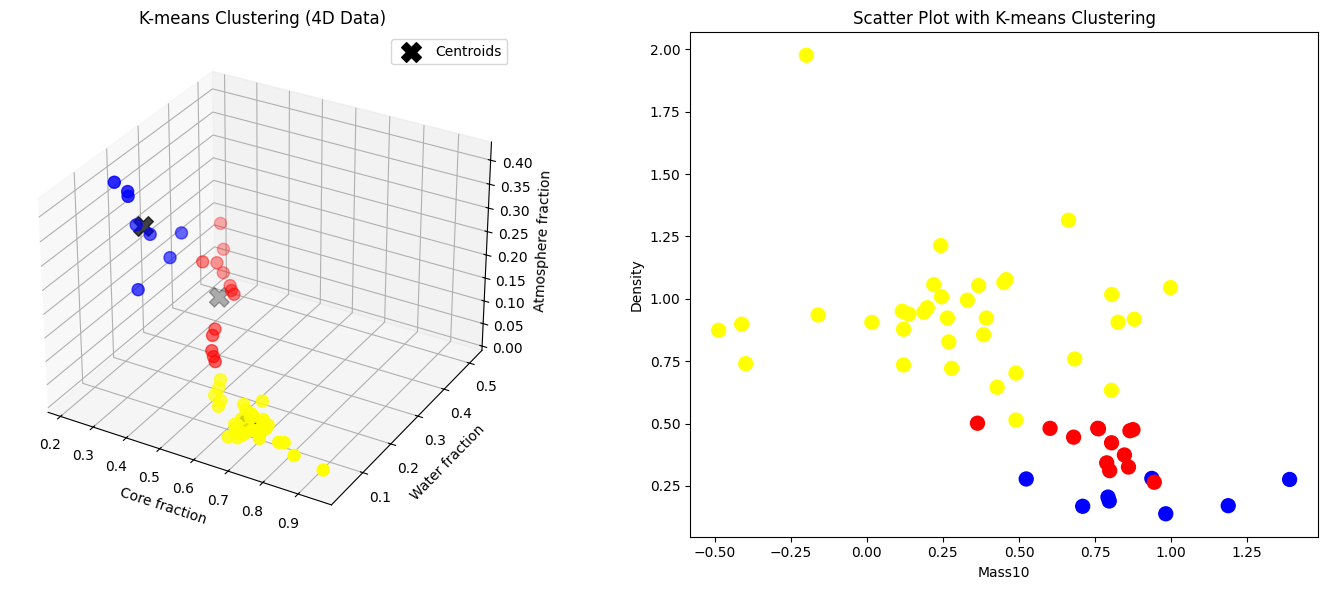

In [64]:
# Combine the lists to create the 4D dataset
X = np.column_stack((merged_df['Core'], merged_df['Mantle'], merged_df['Water'], merged_df['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 10)
labels = kmeans.fit_predict(X)

# Visualize the clusters in a 3D plot
fig = plt.figure(figsize=(14, 6))

# Subplot for 3D plot
ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap=custom_cmap, s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='black', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

# Subplot for 2D scatter plot
ax2 = fig.add_subplot(122)
scatter_2d = ax2.scatter(mass10, density, c=labels, cmap=custom_cmap,s = 100)
ax2.set_title('Scatter Plot with K-means Clustering')
ax2.set_xlabel('Mass10')
ax2.set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
image_name = '3KMeans_HDI.png'
image_format = 'png'
fig.savefig(image_name, format=image_format, dpi=1200)

In [18]:
from sklearn.cluster import KMeans

# Original 4D dataset X
kmeans = KMeans(n_clusters=3, random_state=42,n_init = 50)
labels_original = kmeans.fit_predict(X)
inertia_original = kmeans.inertia_

# Evaluate inertia after removing one dimension
for i in range(X.shape[1]):
    reduced_X = np.delete(X, i, axis=1)
    kmeans = KMeans(n_clusters=3, random_state=42,n_init = 50)
    labels_reduced = kmeans.fit_predict(reduced_X)
    inertia_reduced = kmeans.inertia_

    print(f"Removing dimension {i+1} reduces inertia by: {inertia_original - inertia_reduced}")


Removing dimension 1 reduces inertia by: 0.4007621091586757
Removing dimension 2 reduces inertia by: 0.5605820503422678
Removing dimension 3 reduces inertia by: 0.4933254119020112
Removing dimension 4 reduces inertia by: 0.3633037009984239


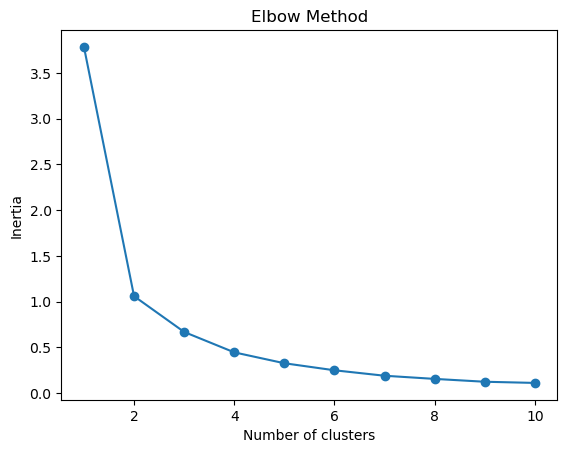

In [161]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k,random_state=42,n_init = 10)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

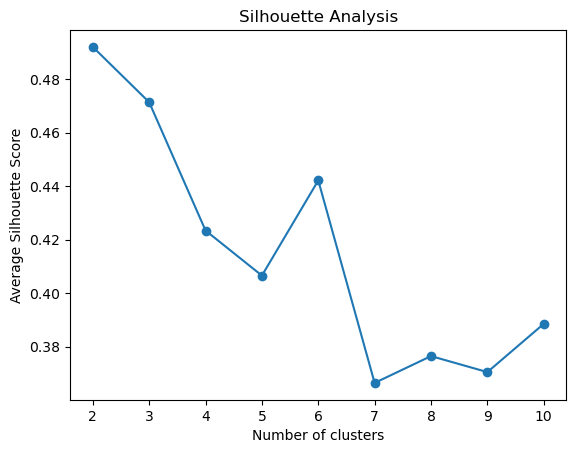

In [383]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

silhouette_scores = []

for k in range(2, 11):  # Silhouette score requires at least 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)

# Plotting
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()


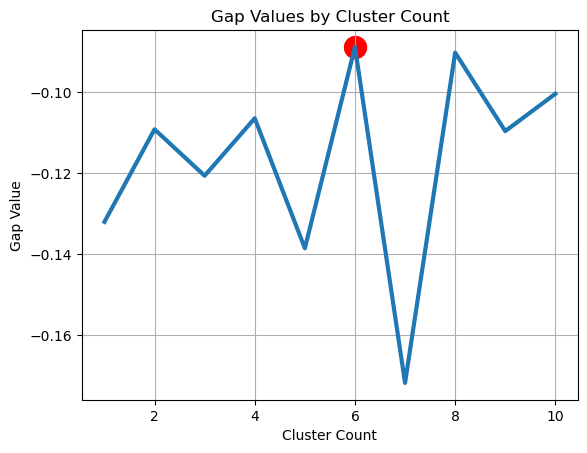

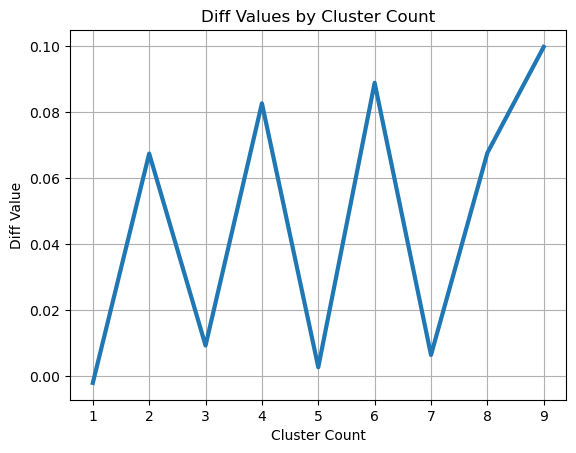

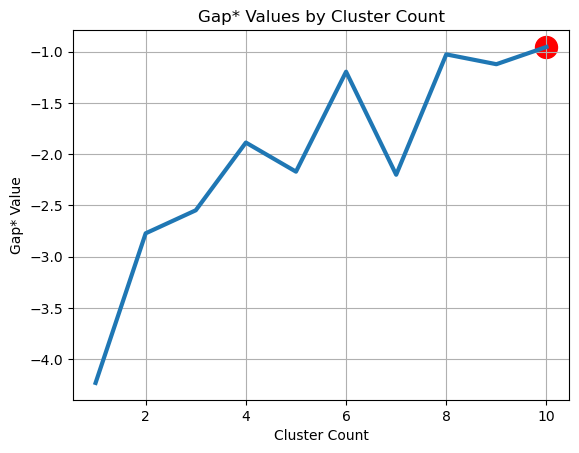

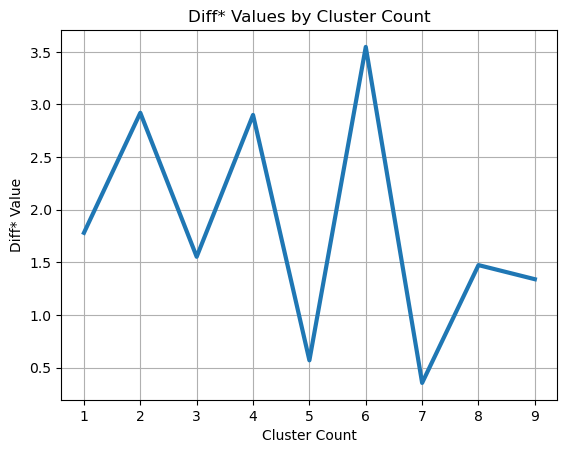

Optimal number of clusters: 6.0


In [34]:
import numpy as np
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
from sklearn.cluster import KMeans

# Assuming you have your data in X
# Generate some random data for demonstration
np.random.seed(42)
X = np.random.rand(100, 4)

# Specify the range of clusters to consider
k_values = range(1, 11)

# Initialize OptimalK
optimal_k = OptimalK(parallel_backend='joblib')

# Compute the optimal number of clusters
optimal_k(X, cluster_array=k_values)

# Plot the Gap Statistic
optimal_k.plot_results()
plt.show()

# Get the optimal number of clusters
optimal_clusters = optimal_k.gap_df.loc[optimal_k.gap_df.gap_value.idxmax(), 'n_clusters']
print(f"Optimal number of clusters: {optimal_clusters}")


In [163]:
planet_rf

,Name,core_rf,mantle_rf,water_rf,atmosphere_rf
0,GJ 3053 b,0.269600,0.093086,0.595130,0.042185
1,GJ 3053 b,0.308783,0.084239,0.530631,0.076347
2,GJ 3053 b,0.313988,0.012816,0.608470,0.064726
3,GJ 3053 b,0.338792,0.093428,0.452135,0.115645
4,GJ 3053 b,0.222114,0.136790,0.616532,0.024565
...,...,...,...,...,...
18736295,TOI-2136 b,0.526454,0.107329,0.319844,0.046373
18736296,TOI-2136 b,0.488766,0.192505,0.294015,0.024714
18736297,TOI-2136 b,0.543987,0.261616,0.043284,0.151112
18736298,TOI-2136 b,0.546981,0.123341,0.258051,0.071627


## Predictions with Errors

In [161]:
unique_planets = planet_rf['Name'].unique()

# Initialize an empty dataframe to store summary statistics
summary_df = pd.DataFrame(columns=['Name', 'Mean_water', 'Std_water', 'Skewness_water', 'Kurtosis_water',
                                    'Mean_core', 'Std_core', 'Skewness_core', 'Kurtosis_core',
                                    'Mean_mantle', 'Std_mantle', 'Skewness_mantle', 'Kurtosis_mantle',
                                    'Mean_atmosphere', 'Std_atmosphere', 'Skewness_atmosphere', 'Kurtosis_atmosphere'])


In [198]:
summary_list = []

for planet in unique_planets:
    data = planet_rf[planet_rf['Name'] == planet]
    
    # Calculate summary statistics for each feature
    mean_values, std_dev_values, skewness_values, kurtosis_values = calculate_summary_statistics(data[['water_rf', 'core_rf', 'mantle_rf', 'atmosphere_rf']])
    
    # Append the summary statistics to the list
    summary_list.append({
        'Name': planet,
        'Mean_water': mean_values[0],
        'Std_water': std_dev_values[0],
        'Skewness_water': skewness_values[0],
        'Kurtosis_water': kurtosis_values[0],
        'Mean_core': mean_values[1],
        'Std_core': std_dev_values[1],
        'Skewness_core': skewness_values[1],
        'Kurtosis_core': kurtosis_values[1],
        'Mean_mantle': mean_values[2],
        'Std_mantle': std_dev_values[2],
        'Skewness_mantle': skewness_values[2],
        'Kurtosis_mantle': kurtosis_values[2],
        'Mean_atmosphere': mean_values[3],
        'Std_atmosphere': std_dev_values[3],
        'Skewness_atmosphere': skewness_values[3],
        'Kurtosis_atmosphere': kurtosis_values[3],
    })

# Convert the list to a DataFrame
summary_df = pd.DataFrame(summary_list)



InvalidIndexError: (slice(None, None, None), 0)

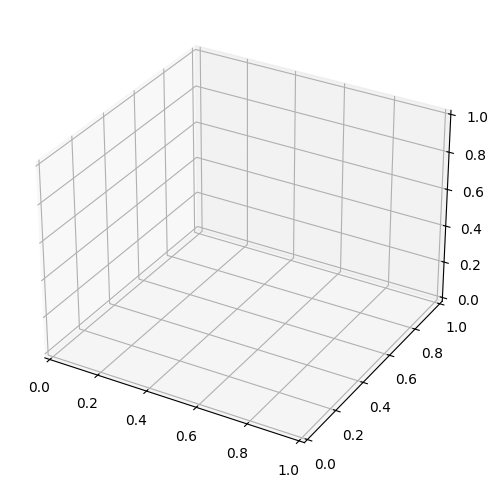

In [197]:
fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(features_for_clustering[:, 0], features_for_clustering[:, 2], features_for_clustering[:, 3], c=labels, cmap="inferno", s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='black', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction')
ax1.set_ylabel('Water fraction')
ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

In [201]:
summary_df

,Name,Mean_water,Std_water,Skewness_water,Kurtosis_water,Mean_core,Std_core,Skewness_core,Kurtosis_core,Mean_mantle,Std_mantle,Skewness_mantle,Kurtosis_mantle,Mean_atmosphere,Std_atmosphere,Skewness_atmosphere,Kurtosis_atmosphere,Cluster
0,GJ 3053 b,0.141697,0.164080,1.544937,2.922946,0.496284,0.356497,0.413767,-1.512386,0.115608,0.132481,1.451506,2.163747,0.246411,0.266727,0.703719,-0.927872,2
1,GJ 3053 c,0.147879,0.153964,1.424576,2.721859,0.456927,0.353421,0.573149,-1.337567,0.103133,0.115926,1.533955,2.720783,0.292061,0.268636,0.411479,-1.286889,1
2,LHS 1478 b,0.141390,0.150775,1.517378,3.432033,0.465039,0.352873,0.542828,-1.376075,0.108487,0.120296,1.477271,2.493713,0.285084,0.264273,0.429054,-1.260049,0
3,TOI-1634 b,0.152361,0.165680,1.292642,1.918078,0.510729,0.353901,0.355388,-1.553003,0.113575,0.127996,1.359978,1.828537,0.223335,0.235733,0.809732,-0.668795,2
4,GJ 3473 b,0.151306,0.154648,1.403664,2.635797,0.453654,0.350977,0.586087,-1.305819,0.102896,0.114496,1.527286,2.706422,0.292144,0.266867,0.392316,-1.311057,1
5,L 98-59 c,0.139160,0.151112,1.562466,3.602199,0.456382,0.354463,0.578064,-1.341367,0.108608,0.120642,1.492179,2.549720,0.295850,0.272569,0.398378,-1.303019,0
6,L 98-59 d,0.136881,0.147530,1.582992,3.582336,0.422964,0.346353,0.744919,-1.092931,0.110789,0.119906,1.536058,2.828312,0.329366,0.284098,0.233453,-1.453526,1
7,K2-146 b,0.150195,0.160490,1.385536,2.415809,0.457073,0.347744,0.609048,-1.286531,0.118701,0.128069,1.393876,2.095171,0.274031,0.263262,0.499137,-1.214050,1
8,K2-146 c,0.152207,0.163997,1.361950,2.111312,0.459278,0.346740,0.602916,-1.285708,0.121655,0.130816,1.386460,2.062960,0.266860,0.265164,0.551051,-1.158563,2
9,GJ 357 b,0.135942,0.147167,1.608100,3.910134,0.453420,0.355023,0.582862,-1.335191,0.105795,0.118340,1.547442,2.839796,0.304843,0.276183,0.338656,-1.377166,2


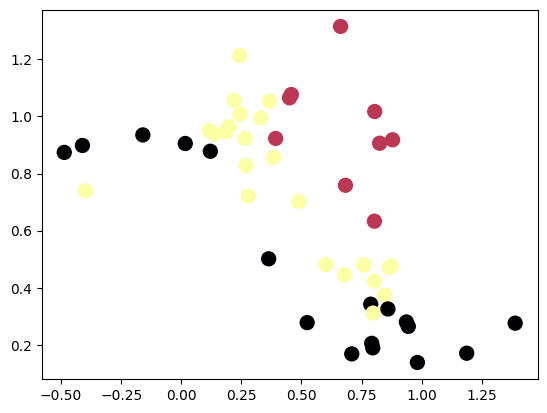

In [206]:
kmeans = KMeans(n_clusters=3, n_init=10)
X = np.column_stack((summary_df['Mean_core'], summary_df['Mean_mantle'], summary_df['Mean_water'], summary_df['Mean_atmosphere']))
labels = kmeans.fit_predict(X)
plt.scatter(merged_df["Mass10"], merged_df["Density"] , c=labels, cmap="inferno",s = 100)

In [179]:
summary_df

,Name,Mean_water,Std_water,Skewness_water,Kurtosis_water,Mean_core,Std_core,Skewness_core,Kurtosis_core,Mean_mantle,Std_mantle,Skewness_mantle,Kurtosis_mantle,Mean_atmosphere,Std_atmosphere,Skewness_atmosphere,Kurtosis_atmosphere,Cluster
0,GJ 3053 b,0.141697,0.164080,1.544937,2.922946,0.496284,0.356497,0.413767,-1.512386,0.115608,0.132481,1.451506,2.163747,0.246411,0.266727,0.703719,-0.927872,1
1,GJ 3053 c,0.147879,0.153964,1.424576,2.721859,0.456927,0.353421,0.573149,-1.337567,0.103133,0.115926,1.533955,2.720783,0.292061,0.268636,0.411479,-1.286889,1
2,LHS 1478 b,0.141390,0.150775,1.517378,3.432033,0.465039,0.352873,0.542828,-1.376075,0.108487,0.120296,1.477271,2.493713,0.285084,0.264273,0.429054,-1.260049,1
3,TOI-1634 b,0.152361,0.165680,1.292642,1.918078,0.510729,0.353901,0.355388,-1.553003,0.113575,0.127996,1.359978,1.828537,0.223335,0.235733,0.809732,-0.668795,1
4,GJ 3473 b,0.151306,0.154648,1.403664,2.635797,0.453654,0.350977,0.586087,-1.305819,0.102896,0.114496,1.527286,2.706422,0.292144,0.266867,0.392316,-1.311057,1
5,L 98-59 c,0.139160,0.151112,1.562466,3.602199,0.456382,0.354463,0.578064,-1.341367,0.108608,0.120642,1.492179,2.549720,0.295850,0.272569,0.398378,-1.303019,1
6,L 98-59 d,0.136881,0.147530,1.582992,3.582336,0.422964,0.346353,0.744919,-1.092931,0.110789,0.119906,1.536058,2.828312,0.329366,0.284098,0.233453,-1.453526,0
7,K2-146 b,0.150195,0.160490,1.385536,2.415809,0.457073,0.347744,0.609048,-1.286531,0.118701,0.128069,1.393876,2.095171,0.274031,0.263262,0.499137,-1.214050,1
8,K2-146 c,0.152207,0.163997,1.361950,2.111312,0.459278,0.346740,0.602916,-1.285708,0.121655,0.130816,1.386460,2.062960,0.266860,0.265164,0.551051,-1.158563,1
9,GJ 357 b,0.135942,0.147167,1.608100,3.910134,0.453420,0.355023,0.582862,-1.335191,0.105795,0.118340,1.547442,2.839796,0.304843,0.276183,0.338656,-1.377166,0


In [189]:
planet_name

array(['GJ 3053 b', 'GJ 3053 c', 'LHS 1478 b', 'TOI-1634 b', 'TOI-1685 b',
       'GJ 3473 b', 'L 98-59 c', 'L 98-59 d', 'K2-146 b', 'K2-146 c',
       'GJ 357 b', 'TOI-1235 b', 'GJ 1132 b', 'LTT 3780 b', 'LTT 3780 c',
       'K2-18 b', 'TOI-776 b', 'GJ 486 b', 'GJ 1214 b', 'GJ 1252 b',
       'TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e',
       'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 h', 'CD-60 8051 b',
       'TOI-270 b', 'TOI-270 c', 'TOI-270 d', 'K2-25 b', 'TOI-269 b',
       'TOI-1231 b', 'AU Mic c', 'GJ 3090 b', 'GJ 367 b', 'GJ 3929 b',
       'GJ 806 b', 'HD 260655 b', 'HD 260655 c', 'Kepler-26 b',
       'Kepler-26 c', 'L 98-59 b', 'LTT 1445 A b', 'LTT 1445 A c',
       'TOI-1075 b', 'TOI-1201 b', 'TOI-1452 b', 'TOI-1470 b',
       'TOI-1470 c', 'TOI-1695 b', 'TOI-1801 b', 'TOI-2136 b',
       'TOI-244 b'], dtype='<U12')

In [13]:
All_with_errors = pd.read_csv(r"C:\Users\silke\ExoMDN\more_examples\Planet_param_with_errors.txt",delimiter = "\t")


In [67]:
every_5000th_row = every_5000th_row.reindex(planet_name)


In [94]:
pl_df = pd.DataFrame()
pl_df["Name"]       = planet_name
pl_df["Mass"]       = mass
pl_df["Mass10"]     = mass10
pl_df["Mass_err"]   = mass_err
pl_df["Radius"]     = radius
pl_df["Radius_err"] = radius_err
pl_df["Density"]    = density
pl_df["Temp"]       = planet_temp
pl_df["Temp_err"]   = 0.02*planet_temp


In [35]:
planet_rf = pd.DataFrame()
planet_rf['Name'] = All_with_errors['Planet Name']
planet_rf['core_rf'] = All_with_errors['core_rf']
planet_rf['mantle_rf'] = All_with_errors['mantle_rf']
planet_rf['water_rf'] = All_with_errors['water_rf']
planet_rf['atmosphere_rf'] = All_with_errors['atmosphere_rf']
unique_entries = planet_rf['Planet Name'].unique()


In [36]:
random_row = planet_rf.loc[planet_rf['PName'] == 'TOI-2136 b'].sample()

In [38]:
random_row = planet_rf.loc[planet_rf['Name'] == unique_entries[10]].sample()

In [110]:
random_dataframe = pd.DataFrame()
for i in range(0,2):
    random_row = planet_rf.loc[planet_rf['Name'] == unique_entries[i]].sample()
    random_dataframe = pd.concat([random_dataframe, random_row], ignore_index=True)


In [144]:
import numpy as np
from scipy.stats import moment, skew, kurtosis
def calculate_summary_statistics(data):
    mean_values = np.mean(data, axis=0)
    std_dev_values = np.std(data, axis=0)
    skewness_values = skew(data, axis=0)
    kurtosis_values = kurtosis(data, axis=0)
    return mean_values, std_dev_values, skewness_values, kurtosis_values

data = planet_rf.loc[planet_rf['Name'] == "GJ 3053 b"]["water_rf"]
mean_values, std_dev_values, skewness_values, kurtosis_values = calculate_summary_statistics(data)

print("Mean:", mean_values)
print("Standard Deviation:", std_dev_values)
print("Skewness:", skewness_values)
print("Kurtosis:", kurtosis_values)


Mean: 0.14169721984778738
Standard Deviation: 0.1640796749558165
Skewness: 1.5449371853236191
Kurtosis: 2.9229457414283626


In [145]:

    summary_statistics_df = pd.concat([summary_statistics_df, {
        'Name': planet_name,
        'Mean': mean_values,  # Assuming you have only one feature ('water_rf') for simplicity
        'Std Dev': std_dev_values,
        'Skewness': skewness_values,
        'Kurtosis': kurtosis_values
    }], ignore_index=True)

In [152]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

def calculate_summary_statistics(data):
    mean_values = np.mean(data, axis=0)
    std_dev_values = np.std(data, axis=0)
    skewness_values = skew(data, axis=0)
    kurtosis_values = kurtosis(data, axis=0)
    return mean_values, std_dev_values, skewness_values, kurtosis_values

# Assuming 'planet_rf' is your DataFrame
unique_planets = planet_rf['Name'].unique()

# Create an empty DataFrame to store results
summary_statistics_df = pd.DataFrame(columns=['Name', 'Mean', 'Std Dev', 'Skewness', 'Kurtosis'])

for planet_name in unique_planets:
    # Filter data for the current planet
    data = planet_rf.loc[planet_rf['Name'] == planet_name]['water_rf']

    # Calculate summary statistics
    mean_values, std_dev_values, skewness_values, kurtosis_values = calculate_summary_statistics(data)
    new_row = {
    'Name': planet_name,
    'Mean': mean_values,
    'Std Dev': std_dev_values,
    'Skewness': skewness_values,
    'Kurtosis': kurtosis_values
    }
    df.loc[len(df)] = new_row
# Display or use the summary_statistics_df as needed
print(summary_statistics_df)


Empty DataFrame
Columns: [Name, Mean, Std Dev, Skewness, Kurtosis]
Index: []


In [153]:
summary_statistics_df

,Name,Mean,Std Dev,Skewness,Kurtosis


In [143]:
planet_rf.loc[planet_rf['Name'] == "GJ 3053 b"]["water_rf"]

0         5.951296e-01
1         5.306310e-01
2         6.084698e-01
3         4.521353e-01
4         6.165315e-01
              ...     
391495    1.993816e-18
391496    6.022839e-23
391497    1.156030e-17
391498    1.045378e-19
391499    1.138031e-15
Name: water_rf, Length: 391500, dtype: float64

<Axes: xlabel='mantle_rf', ylabel='Density'>

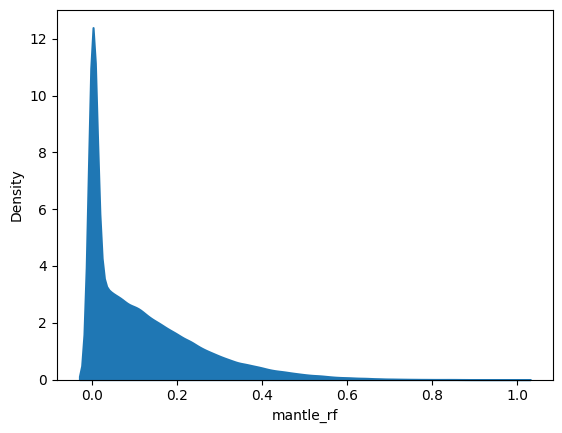

In [138]:
sns.kdeplot(planet_rf.loc[planet_rf['Name'] == "GJ 3053 b"]["mantle_rf"], fill=True, alpha=1, linewidth=1.5, clip_on=False)

In [98]:
merged_df = pl_df.merge(random_dataframe, how='inner', left_on='Name', right_on='Name')


In [154]:
unique_planets = df['Name'].unique()

# Initialize an empty dataframe to store summary statistics
summary_df = pd.DataFrame(columns=['Name', 'Mean_water', 'Std_water', 'Skewness_water', 'Kurtosis_water',
                                    'Mean_core', 'Std_core', 'Skewness_core', 'Kurtosis_core',
                                    'Mean_mantle', 'Std_mantle', 'Skewness_mantle', 'Kurtosis_mantle',
                                    'Mean_atmosphere', 'Std_atmosphere', 'Skewness_atmosphere', 'Kurtosis_atmosphere'])


In [156]:
pl_df

,Name,Mass,Mass10,Mass_err,Radius,Radius_err,Density,Temp,Temp_err
0,GJ 3053 b,6.380,0.804821,0.460,1.635,0.046,1.017302,378.9,7.578
1,GJ 3053 c,1.760,0.245513,0.170,1.169,0.038,1.008114,708.9,14.178
2,LHS 1478 b,2.330,0.367356,0.200,1.242,0.051,1.053253,595.0,11.900
3,TOI-1634 b,7.570,0.879096,0.720,1.773,0.077,0.918298,921.0,18.420
4,TOI-1685 b,3.090,0.489958,0.590,1.700,0.070,0.513951,1069.0,21.380
5,GJ 3473 b,1.860,0.269513,0.300,1.264,0.050,0.827400,773.0,15.460
6,L 98-59 c,2.420,0.383815,0.350,1.340,0.070,0.856041,517.0,10.340
7,L 98-59 d,2.310,0.363612,0.460,1.580,0.080,0.501381,409.0,8.180
8,K2-146 b,5.770,0.761176,0.180,2.050,0.060,0.478834,590.0,11.800
9,K2-146 c,7.490,0.874482,0.240,2.190,0.070,0.475625,520.0,10.400


In [187]:
mass10

array([ 0.80482068,  0.24551267,  0.36735592,  0.87909588,  0.48995848,
        0.26951294,  0.38381537,  0.36361198,  0.76117581,  0.87448182,
        0.26481782,  0.82542612,  0.22010809,  0.39269695,  0.84633711,
        0.93651374,  0.60205999,  0.45024911,  0.79657433,  0.12057393,
        0.13798673,  0.11660774, -0.41116827, -0.15989391,  0.01661555,
        0.12090282, -0.4867824 ,  0.66275783,  0.19865709,  0.78816837,
        0.6794279 ,  1.38916608,  0.94448267,  1.18752072,  0.98227123,
        0.52374647, -0.19859629,  0.24303805,  0.2787536 ,  0.33041377,
        0.48995848,  0.70926996,  0.79239169, -0.39794001,  0.4578819 ,
        0.18752072,  0.99782308,  0.79795964,  0.68304704,  0.86451108,
        0.85973857,  0.80345712,  0.75876054,  0.80413943,  0.42813479])

In [188]:
planet_name

array(['GJ 3053 b', 'GJ 3053 c', 'LHS 1478 b', 'TOI-1634 b', 'TOI-1685 b',
       'GJ 3473 b', 'L 98-59 c', 'L 98-59 d', 'K2-146 b', 'K2-146 c',
       'GJ 357 b', 'TOI-1235 b', 'GJ 1132 b', 'LTT 3780 b', 'LTT 3780 c',
       'K2-18 b', 'TOI-776 b', 'GJ 486 b', 'GJ 1214 b', 'GJ 1252 b',
       'TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e',
       'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 h', 'CD-60 8051 b',
       'TOI-270 b', 'TOI-270 c', 'TOI-270 d', 'K2-25 b', 'TOI-269 b',
       'TOI-1231 b', 'AU Mic c', 'GJ 3090 b', 'GJ 367 b', 'GJ 3929 b',
       'GJ 806 b', 'HD 260655 b', 'HD 260655 c', 'Kepler-26 b',
       'Kepler-26 c', 'L 98-59 b', 'LTT 1445 A b', 'LTT 1445 A c',
       'TOI-1075 b', 'TOI-1201 b', 'TOI-1452 b', 'TOI-1470 b',
       'TOI-1470 c', 'TOI-1695 b', 'TOI-1801 b', 'TOI-2136 b',
       'TOI-244 b'], dtype='<U12')

In [88]:
merged_df = pd.merge(random_dataframe, pl_df, on='Name', how='left')


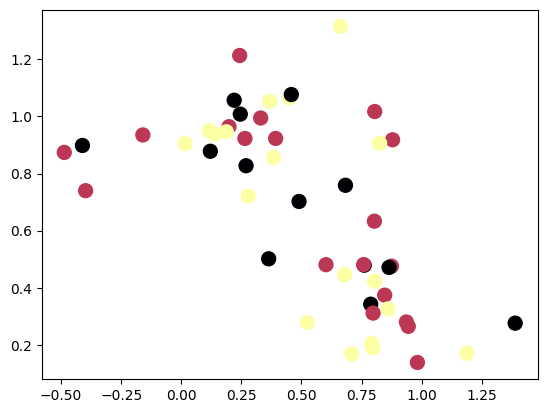

In [75]:
X = np.column_stack((merged_df['core_rf'], merged_df['mantle_rf'], merged_df['water_rf'], merged_df['atmosphere_rf']))
kmeans = KMeans(n_clusters=3,n_init = 100)
labels = kmeans.fit_predict(X)
plt.scatter(merged_df["Mass10"], merged_df["Density"] , c=labels, cmap="inferno",s = 100)

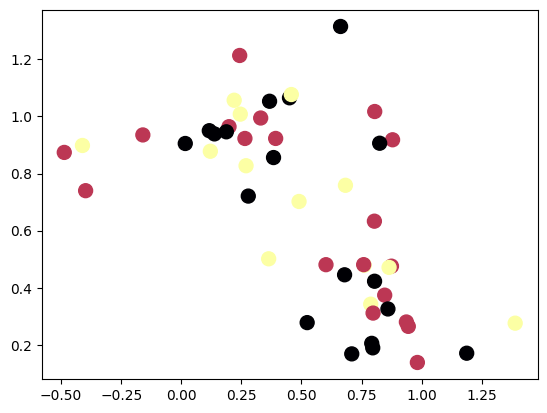

In [200]:
X = np.column_stack((merged_df['core_rf'], merged_df['mantle_rf'], merged_df['water_rf'], merged_df['atmosphere_rf']))
kmeans = KMeans(n_clusters=3, n_init=10)
summary_df['Cluster'] = kmeans.fit_predict(X)
labels = kmeans.fit_predict(X)
plt.scatter(merged_df["Mass10"], merged_df["Density"] , c=labels, cmap="inferno",s = 100)

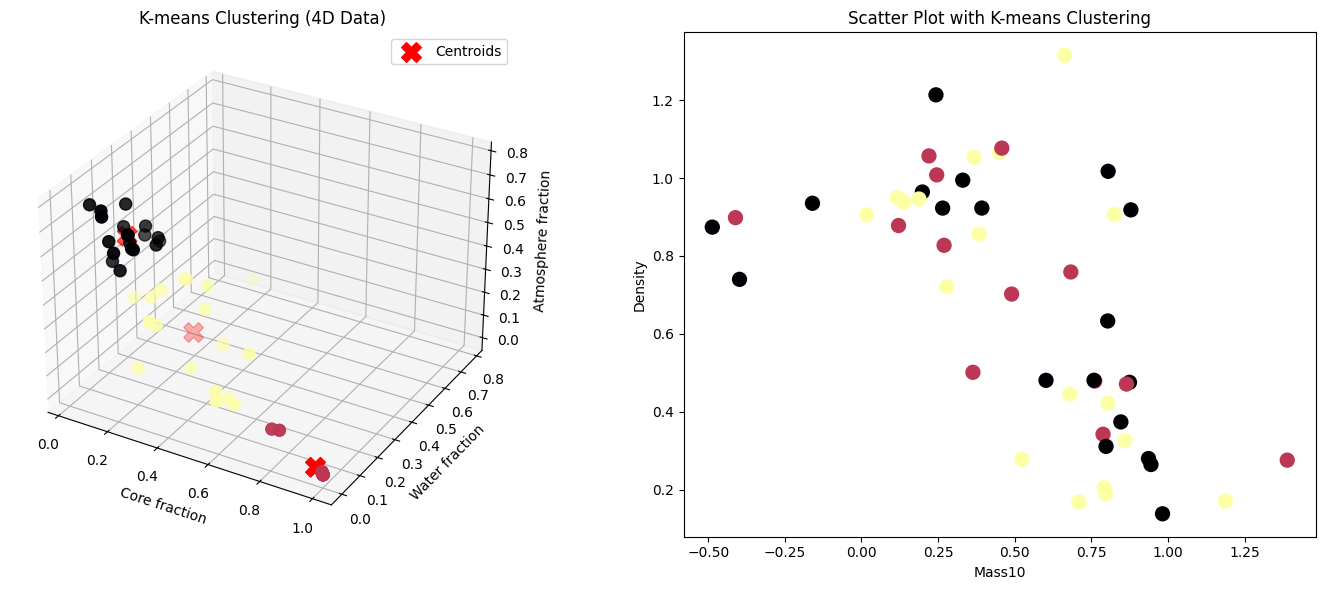

In [62]:

# Combine the lists to create the 4D dataset
X = np.column_stack((merged_df['core_rf'], merged_df['mantle_rf'], merged_df['water_rf'], merged_df['atmosphere_rf']))
# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=3,n_init = 50)
labels = kmeans.fit_predict(X)

# Visualize the clusters in a 3D plot
fig = plt.figure(figsize=(14, 6))

# Subplot for 3D plot
ax1 = fig.add_subplot(121, projection='3d')
scatter_3d = ax1.scatter(X[:, 0], X[:, 2], X[:, 3], c=labels, cmap='inferno', s=75)
centroids = kmeans.cluster_centers_
ax1.scatter(centroids[:, 0], centroids[:, 2], centroids[:, 3], c='red', marker='X', s=200, label='Centroids')
ax1.set_title('K-means Clustering (4D Data)')
ax1.set_xlabel('Core fraction'); ax1.set_ylabel('Water fraction'); ax1.set_zlabel('Atmosphere fraction')
ax1.legend()

# Subplot for 2D scatter plot
ax2 = fig.add_subplot(122)
scatter_2d = ax2.scatter(merged_df["Mass10"], merged_df["Density"], c=labels, cmap='inferno',s = 100)
ax2.set_title('Scatter Plot with K-means Clustering'); ax2.set_xlabel('Mass10'); ax2.set_ylabel('Density')

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
plt.show()



In [25]:
# Sample data
main_list = unique_entries
names = planet_name


# Zip the three lists together
planet_data = list(zip(planet_name, mass10, density))

# Filter the data based on the main list
filtered_data = [planet for planet in planet_data if planet[0] in main_list]

# Unzip the filtered data
filtered_names, filtered_mass, filtered_density = zip(*filtered_data)

# Print the result
print("Filtered Names:", filtered_names)
print("Filtered Mass:", filtered_mass)
print("Filtered density:", filtered_density)


Filtered Names: ('GJ 3053 b', 'GJ 3053 c', 'LHS 1478 b', 'TOI-1634 b', 'GJ 3473 b', 'L 98-59 c', 'L 98-59 d', 'K2-146 b', 'K2-146 c', 'GJ 357 b', 'TOI-1235 b', 'GJ 1132 b', 'LTT 3780 b', 'LTT 3780 c', 'K2-18 b', 'TOI-776 b', 'GJ 486 b', 'GJ 1214 b', 'TRAPPIST-1 b', 'TRAPPIST-1 c', 'TRAPPIST-1 d', 'TRAPPIST-1 e', 'TRAPPIST-1 f', 'TRAPPIST-1 g', 'TRAPPIST-1 h', 'CD-60 8051 b', 'TOI-270 b', 'TOI-270 c', 'TOI-270 d', 'K2-25 b', 'TOI-269 b', 'TOI-1231 b', 'AU Mic c', 'GJ 3090 b', 'GJ 3929 b', 'GJ 806 b', 'HD 260655 b', 'HD 260655 c', 'Kepler-26 b', 'Kepler-26 c', 'L 98-59 b', 'LTT 1445 A b', 'LTT 1445 A c', 'TOI-1201 b', 'TOI-1452 b', 'TOI-1470 b', 'TOI-1470 c', 'TOI-1695 b', 'TOI-1801 b', 'TOI-2136 b')
Filtered Mass: (0.8048206787211624, 0.24551266781414982, 0.367355921026019, 0.8790958795000727, 0.26951294421791633, 0.38381536598043126, 0.36361197989214433, 0.7611758131557314, 0.8744818176994665, 0.2648178230095365, 0.8254261177678232, 0.22010808804005508, 0.39269695325966575, 0.846337112

In [28]:
# Combine the lists to create the 4D dataset
X = np.column_stack((random_dataframe['Core'], random_dataframe['Mantle'], random_dataframe['Water'], random_dataframe['Atmosphere']))

# Apply K-means clustering with 3 clusters (adjust as needed)
kmeans = KMeans(n_clusters=2,n_init = 10)
labels = kmeans.fit_predict(X)

scatter(filtered_mass, filtered_density, c=labels, cmap=custom_cmap,s = 100)

# Adjust layout for better spacing
plt.tight_layout(w_pad=5.0)
plt.show()

KeyError: 'Core'